# Lakes

Multiple ERA5 static climate fields, for exaple lake cover or vegetation, were recently updated from V15 to V20. For a full comparison of how these fields have changed see `A1.V20_vs_V15.ipynb`.

Moreover, there is also additional information such as how lake cover varies month-to-month and the salinity of lakes.

Given this updated information, it is of interest to establish whether a model trained using this new information can make more accurate predicitions than a model without. If so, this indicates that the updated fields are an improvement, i.e. they more closely approximate the real world.

We consider the following predictive models:

* V15: Time varying ERA5 fields + the following static V15 climate fields: 'lsm','cl','dl','cvh','cvl','si10',
* V20: Time varying ERA5 fields, the static V15 climate fields listed above + V20 corrections to each of those fields



2016 2017, predict on 2019


---


## 0. Global variables

First we will declare some variables, functions and useful calculations that will be shared among the sections below. If you just want to see the analysis, skip to `1.V15 vs V20`.

In [23]:
#VARIABLES

V15_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_2016/'
V20_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016/'



In [115]:
# FUNCTIONS
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 

def calculate_delta_field(filename,parameter):
    
    
    """
    Function to determine the change in a parameter when going from V15 to V20
    """
    
    root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
    version = ['v015', 'v020']
    
    ds = [] #Array to hold results
    for v in version:
        path = root+f'climate.{v}/climate.{v}/639l_2/{filename}'
        ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName':parameter}) #only want this one parameter
        
        ds.append(ds_i)
        
    #Take the difference, and make it a nice pandas df    
    delta_field = ds[1] - ds[0] #V20 - V15
    delta_field =  delta_field.assign_coords({"longitude": (((delta_field.longitude + 180) % 360) - 180)}) #long3 ---> long1
    delta_field = delta_field.to_dataframe().reset_index()
    
    V20_df = ds[1].to_dataframe().reset_index()
    V15_df = ds[0].to_dataframe().reset_index()

    if parameter == '10si': #seaice shortname is inverse to variable name
        parameter='si10'
    
    delta_field[f'V15_{parameter}'] = V15_df[parameter]
    delta_field[f'V20_{parameter}'] = V20_df[parameter]
    delta_field = delta_field.rename(columns={f'{parameter}': f'change_in_{parameter}'})
    delta_field[f'percentage_change_in_{parameter}'] = (delta_field[f'V20_{parameter}'] - delta_field[f'V15_{parameter}']) / delta_field[f'V15_{parameter}']

    return delta_field


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
    """Hacky function plotting the value of `z` at latitude/longitude points
       as a scatter map"""

    try:
        x = ds.longitude
        y = ds.latitude
    except: # different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title,fontsize=30)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    
    
    
    
def load_predictions(model):

    """For this model, load the predictions and determine the prediction error"""
    
    df = pd.read_parquet(model+'predictions.parquet')
    
    #Calculate some extra columns
    df['predicion_bias'] = df.MODIS_LST - df.predictions
    df['predicion_error'] = abs(df.MODIS_LST - df.predictions)


    print("Mean/Median/Std prediction bias:", df['predicion_bias'].mean(), df['predicion_bias'].median(),df['predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['predicion_error'].mean(), df['predicion_error'].median(),df['predicion_error'].std())

    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 


    return df,df_grouped



def plot_distribution(df,x,xlabel):
    

    """Plot the distribution of the quantity `x` in df """

    #Setup plot env
    h,w = 20,20
    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    sns.histplot(df[x], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')

    # Config
    ax1.set_xlabel(xlabel)

    ax1.axvline(0,c='0.5', linestyle='--')
    
    #Prints
    print ('Number of samples:', len(df))
    plt.show()
    

In [80]:
#CALCULATIONS

#Calculate all the delta fields i.e. the change in parameter V15-->V20
clake_delta_field  = calculate_delta_field('clake','cl')        #How does cl change?
seaice_delta_field = calculate_delta_field('cicecap','10si')    #How does seaice change
cvh_delta_field    = calculate_delta_field('cvh','cvh')         #How does cvh change?
cvl_delta_field    = calculate_delta_field('cvl','cvl')         #How does cvl change
lsm_delta_field    = calculate_delta_field('lsmoro','lsm')      #How does lsm change?

#Bring all the delta fields together
change_in_fields = pd.concat([clake_delta_field,seaice_delta_field,cvh_delta_field,cvl_delta_field,lsm_delta_field],axis=1)
change_in_fields = change_in_fields.loc[:,~change_in_fields.columns.duplicated()] #remove duplicated column names that arise due to the concat


#Create classification columns
#Boolean if change in X > tolerance
tolerance = 0.1

def classify(x,tol):
    
    if abs(x) > tol:
        return True
    else:
        return False
for parameter in ['cl','si10','cvh','cvl','lsm']:
    change_in_fields[f'{parameter}_change_is_significant'] = change_in_fields.apply(lambda x : classify(x[f'change_in_{parameter}'],tolerance), axis = 1)

---


## 1. V15 vs V20

In [26]:
V15_predictions,V15_predictions_averaged = load_predictions(V15_model)
V20_predictions,V20_predictions_averaged = load_predictions(V20_model)

Mean/Median/Std prediction bias: -0.011915671 0.09698486 4.2003675
Mean/Median/Std prediction error: 3.120495 2.3731995 2.8117125
Mean/Median/Std prediction bias: -0.00080437923 0.08718872 4.1788526
Mean/Median/Std prediction error: 3.1157644 2.375702 2.7847474


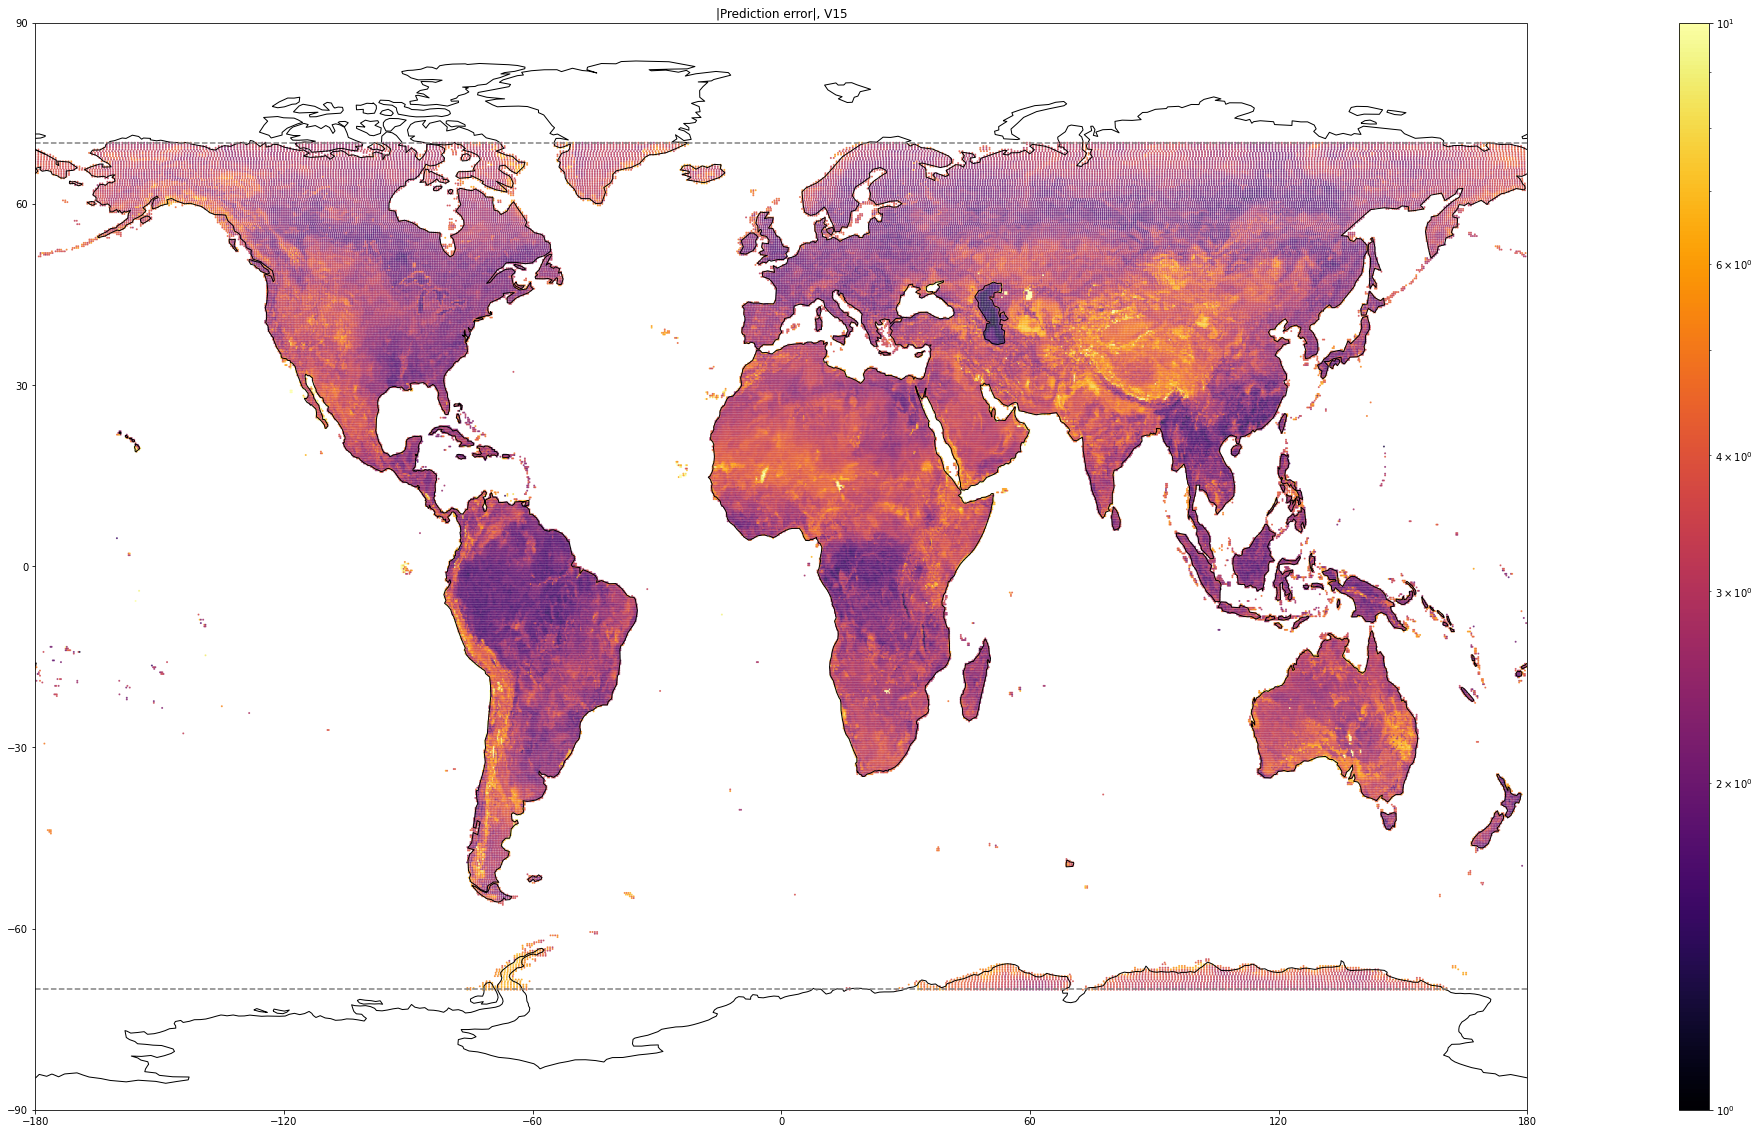

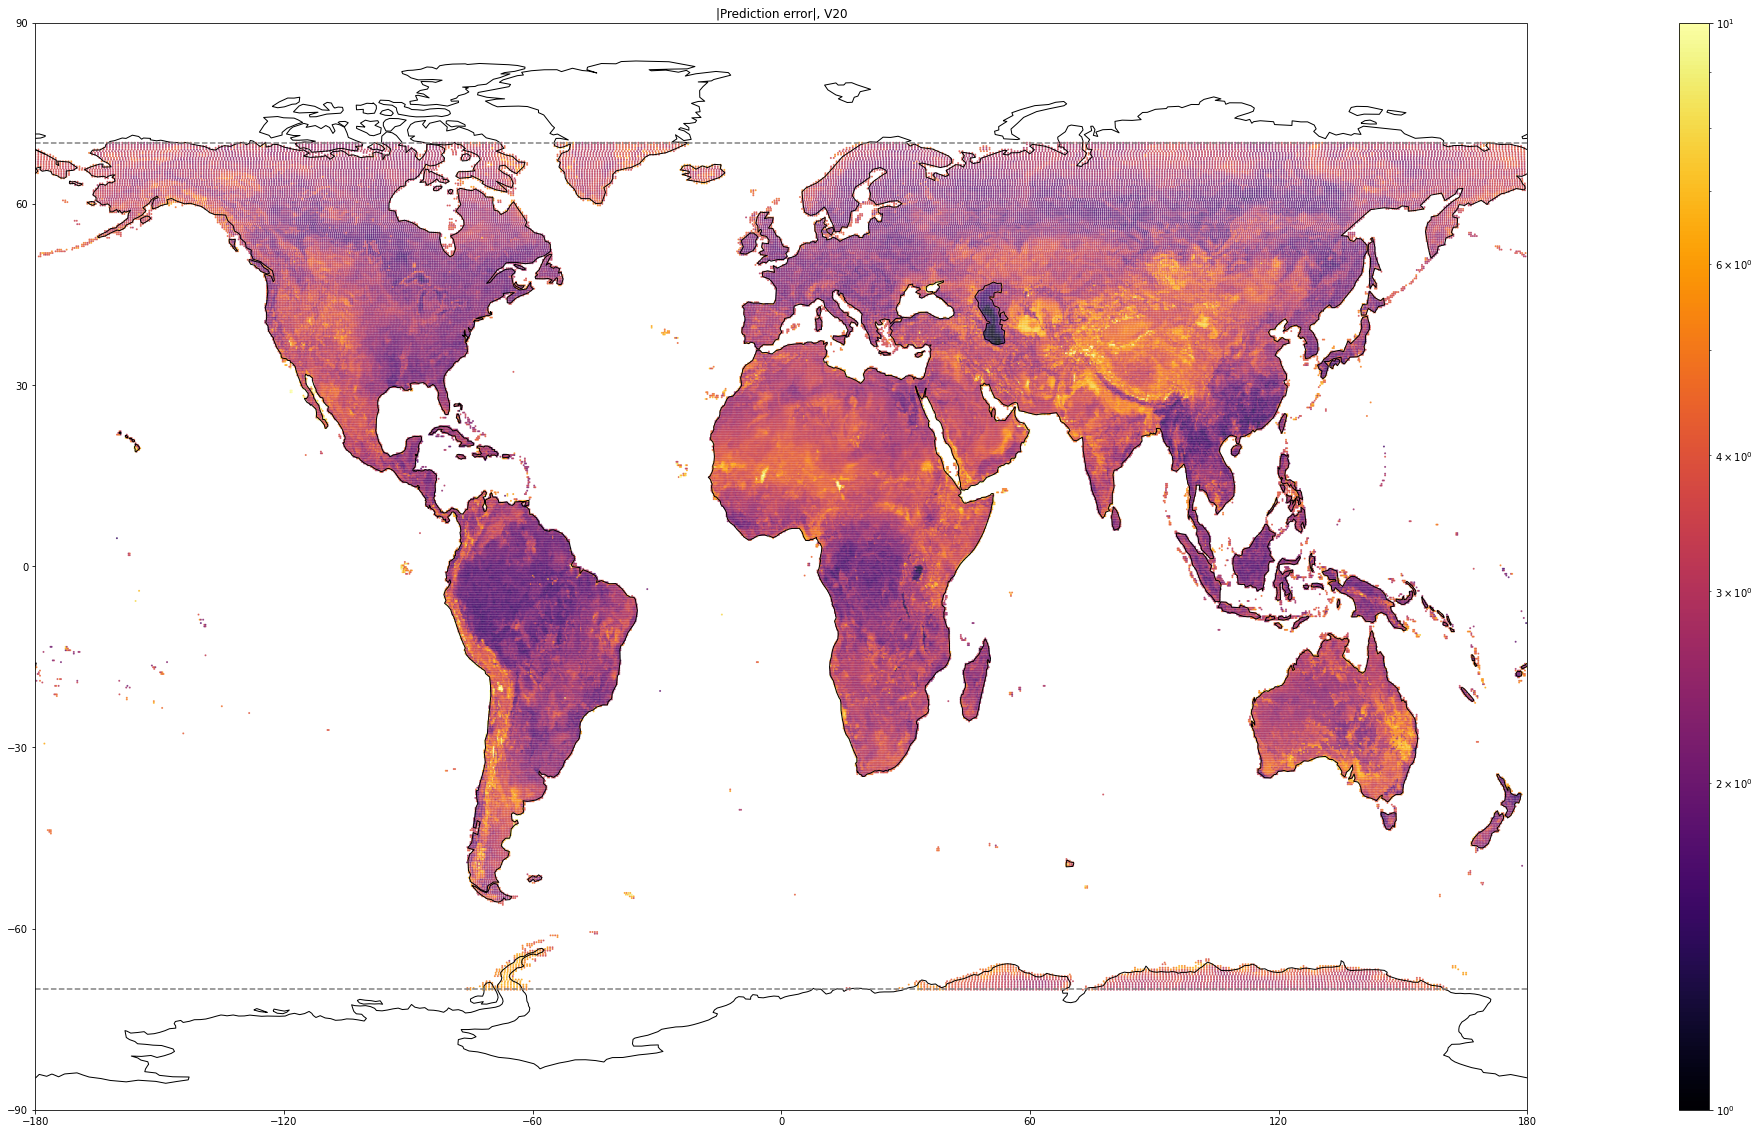

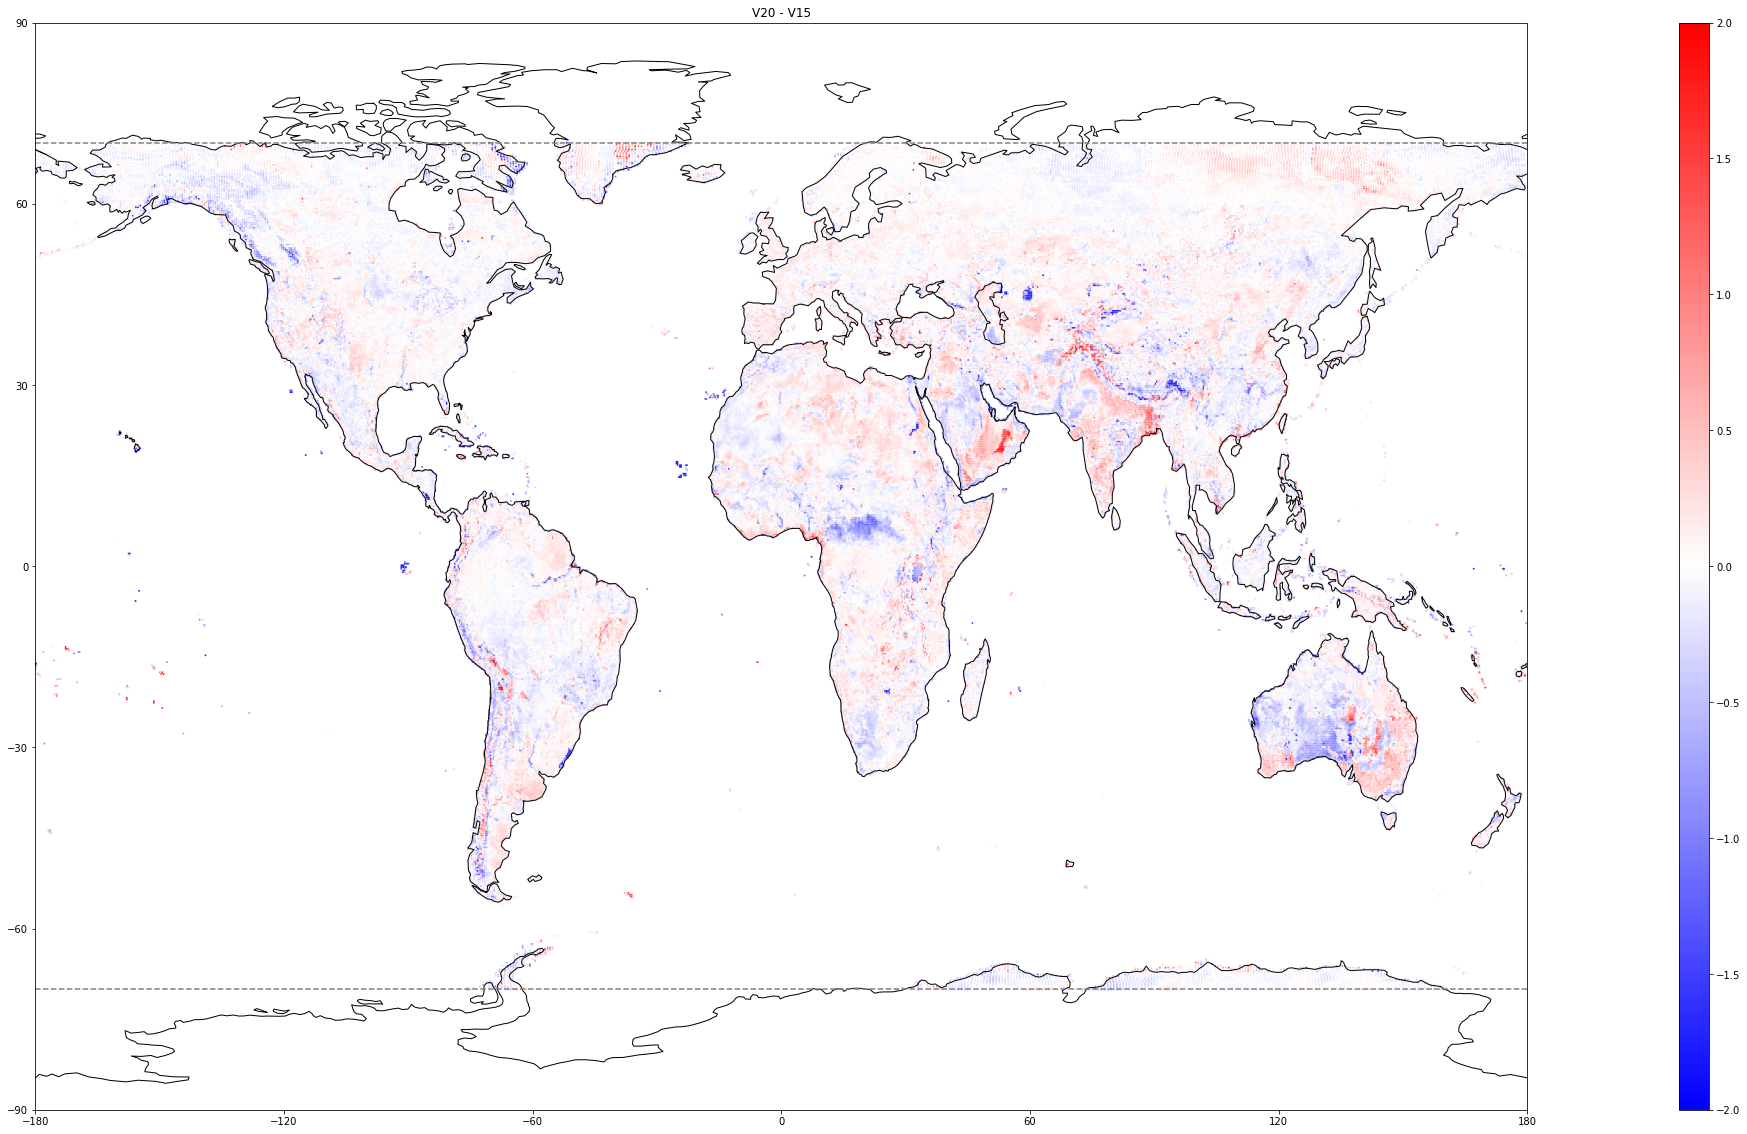

In [40]:
#Plot the map of the prediction error  
cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10
plot_map(V15_predictions_averaged,'predicion_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15',limits=None,markersize=1)
plot_map(V20_predictions_averaged,'predicion_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20',limits=None,markersize=1)

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_predictions_averaged.latitude_ERA, 
        'longitude_ERA':  V20_predictions_averaged.longitude_ERA,
        'MODIS_LST':      V20_predictions_averaged.MODIS_LST,
        'V15_prediction': V15_predictions_averaged.predictions,
        'V20_prediction': V20_predictions_averaged.predictions,
        'V15_error':      V15_predictions_averaged.predicion_error,
        'V20_error':      V20_predictions_averaged.predicion_error,
        'delta':          V20_predictions_averaged.predicion_error - V15_predictions_averaged.predicion_error}
V20_V15 = pd.DataFrame(data)    
plot_map(V20_V15,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15',limits=None,markersize=1)

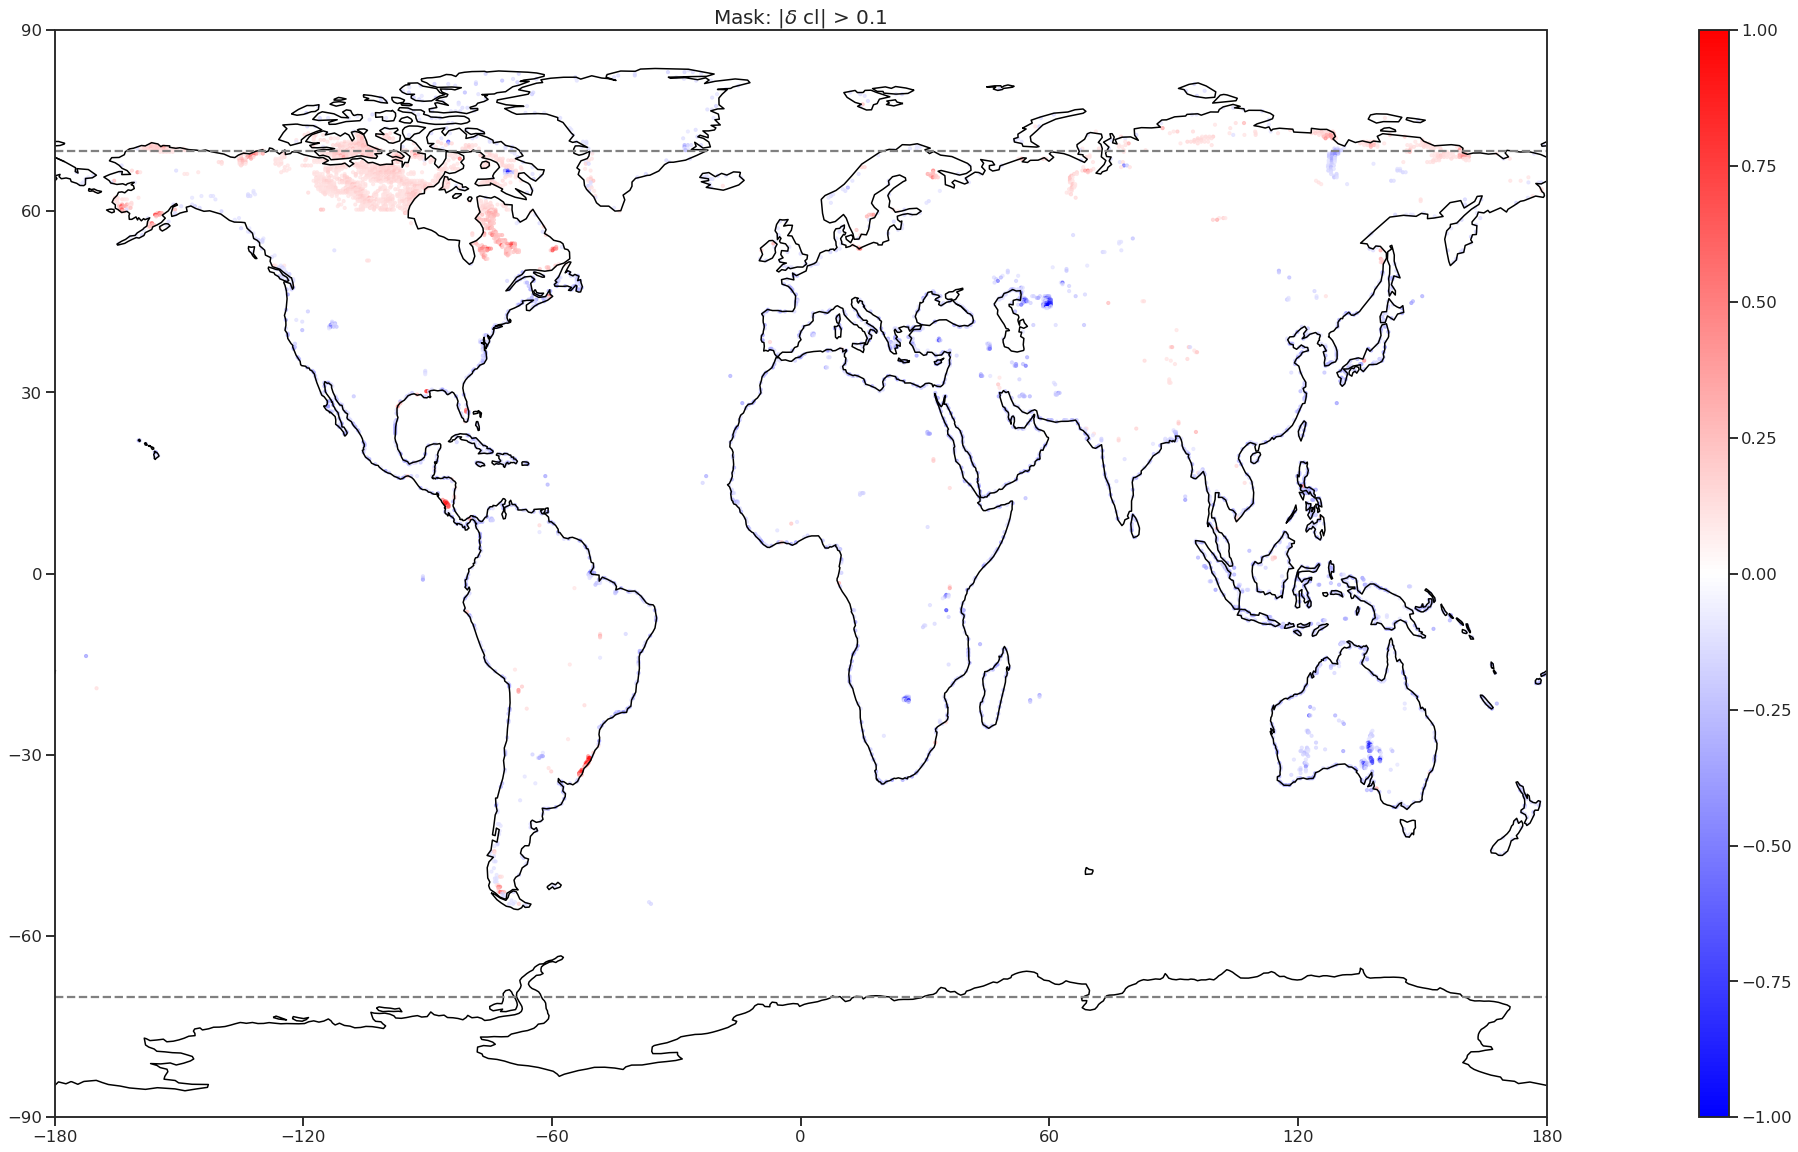

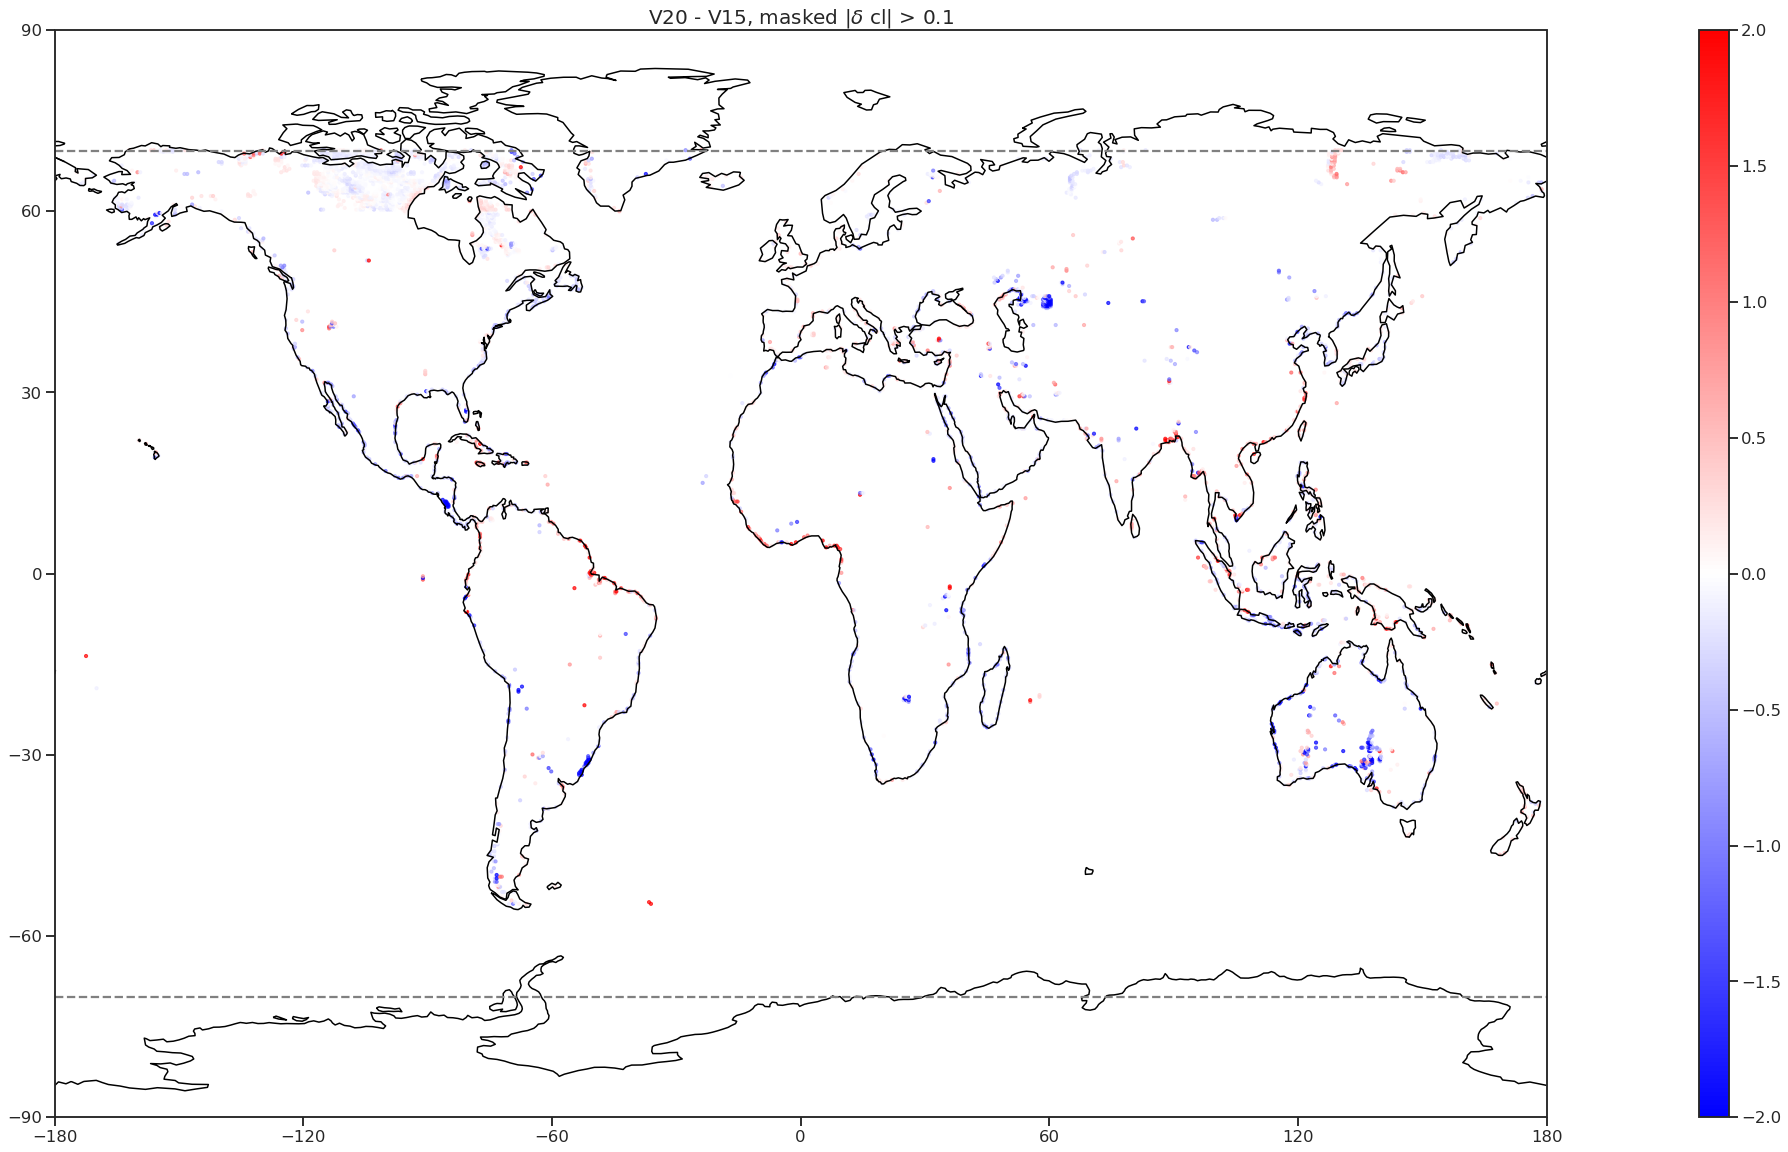

Number of samples: 4314


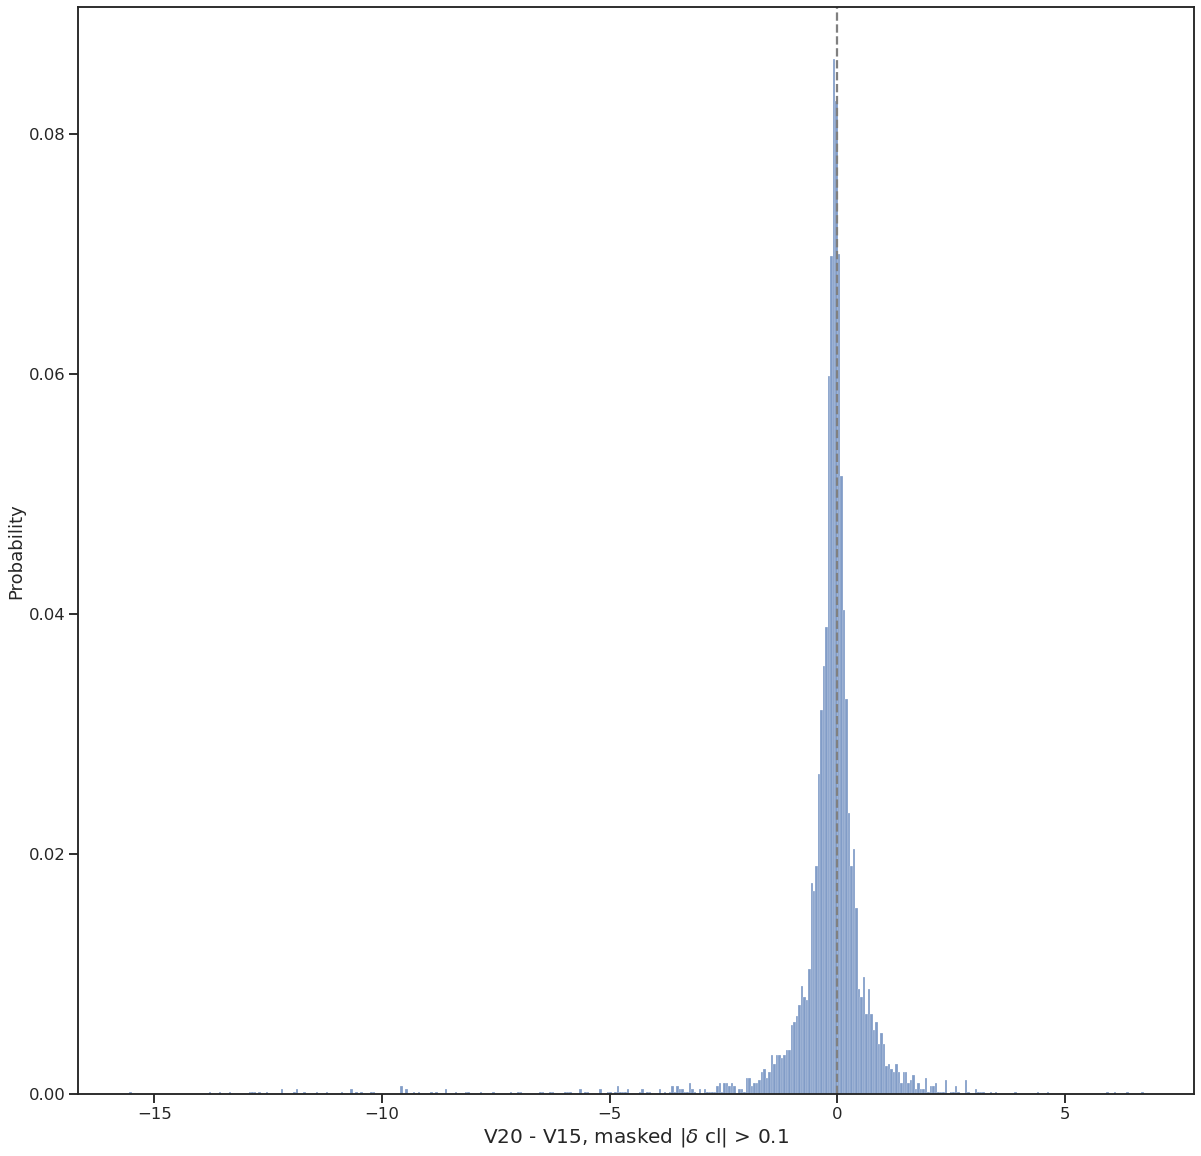

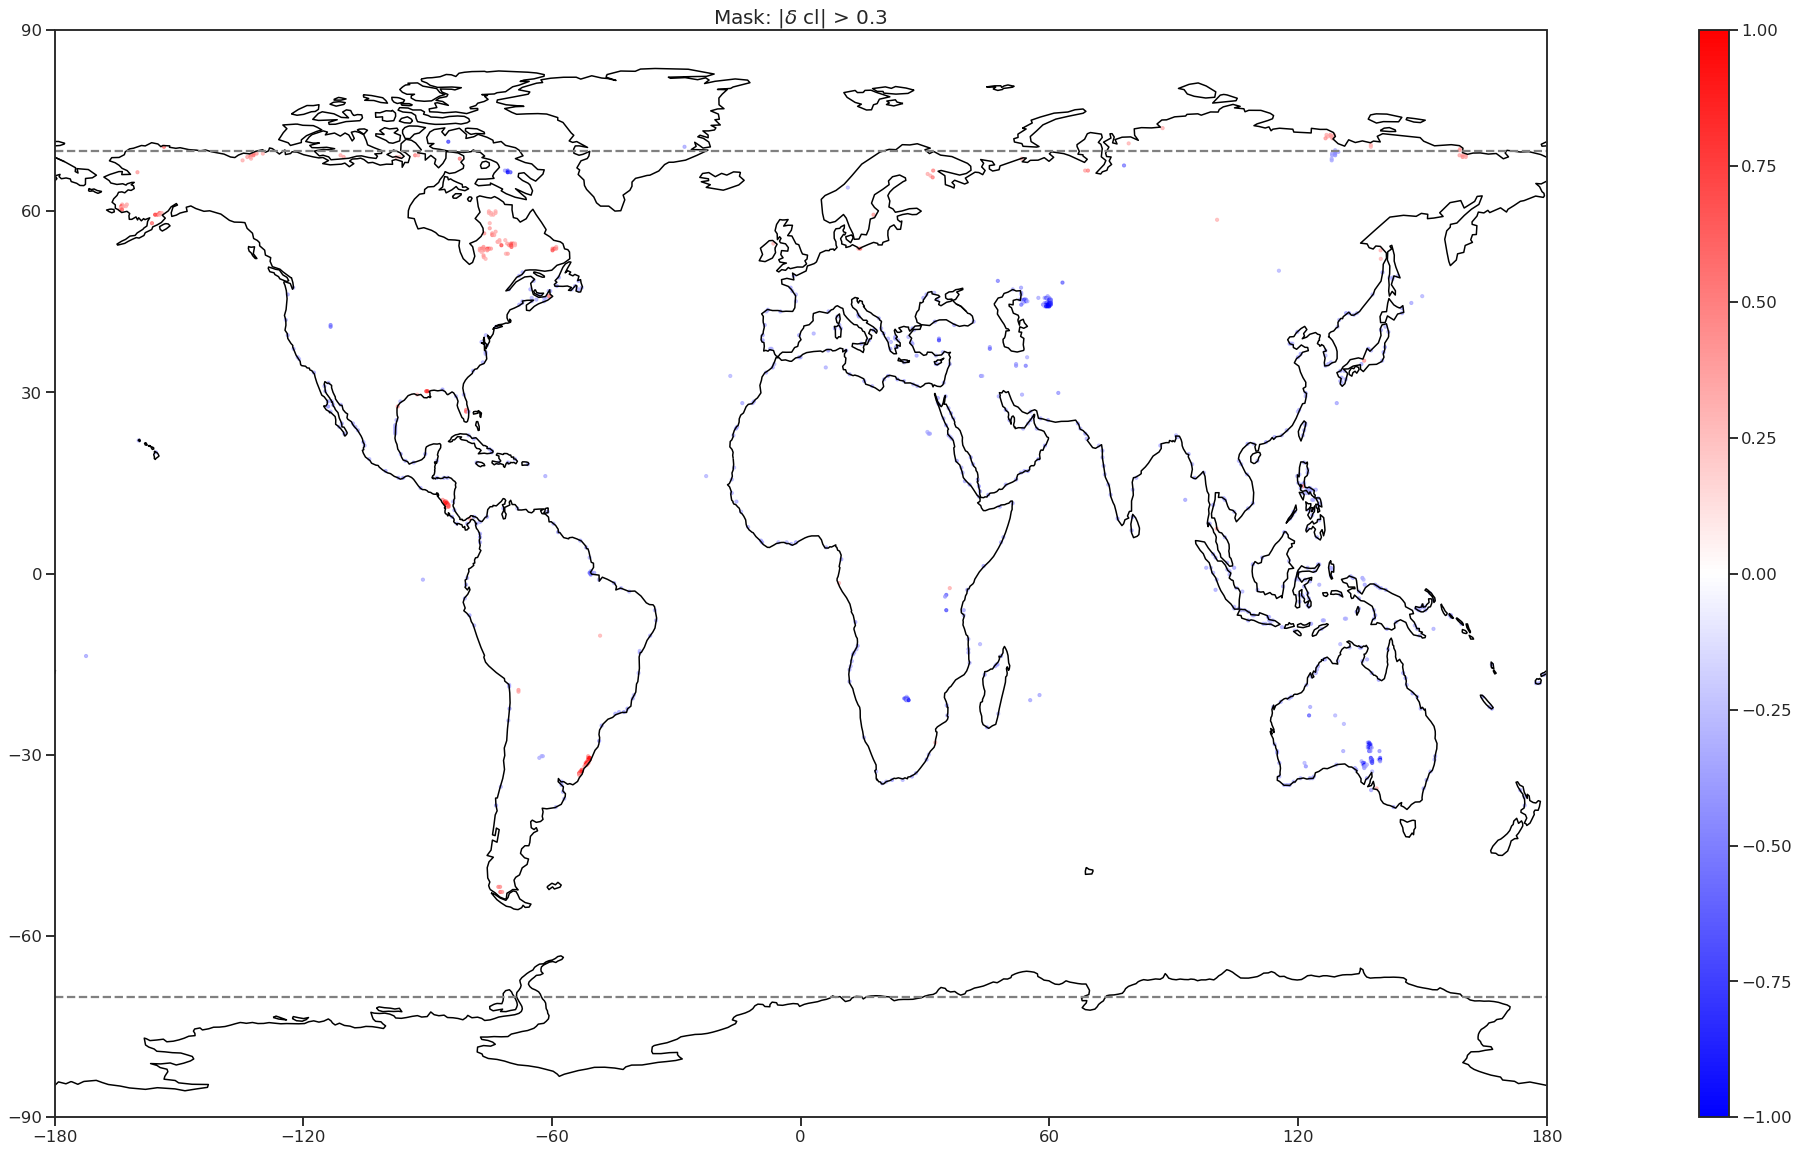

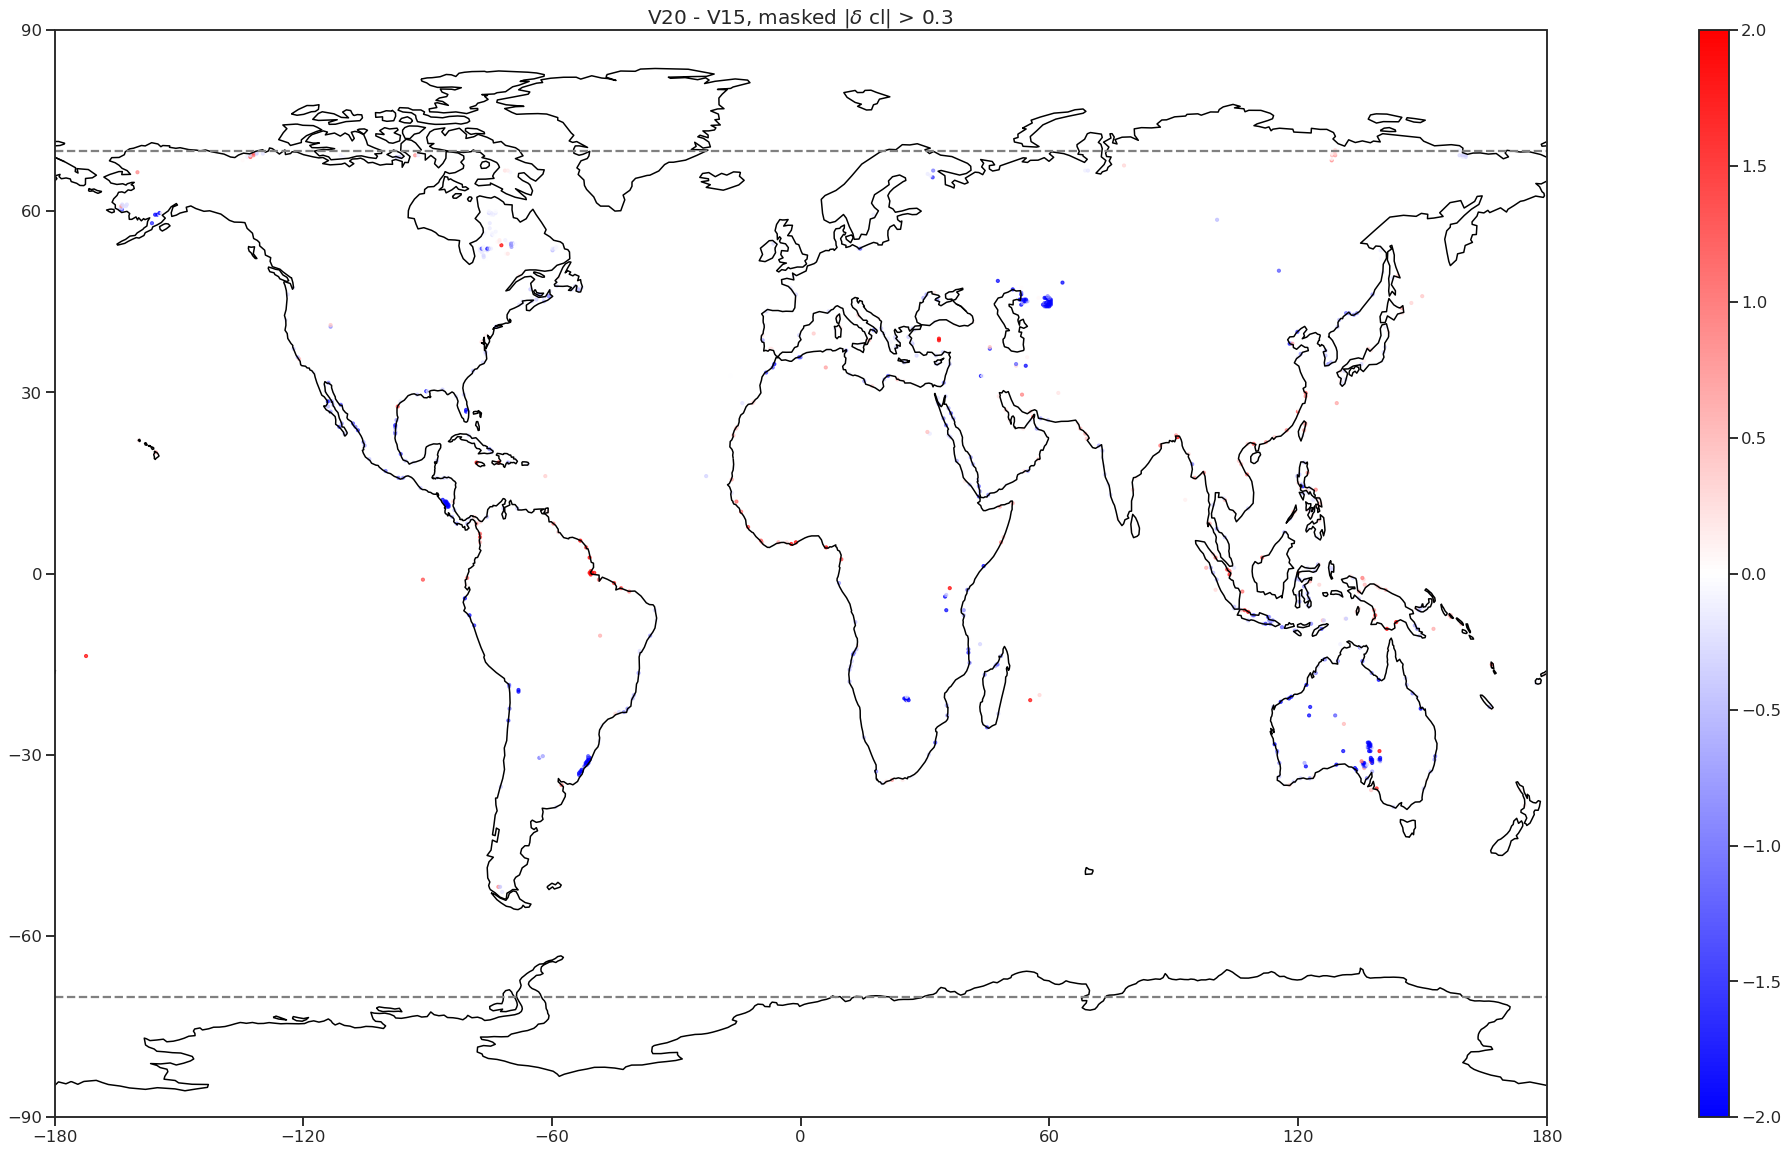

Number of samples: 908


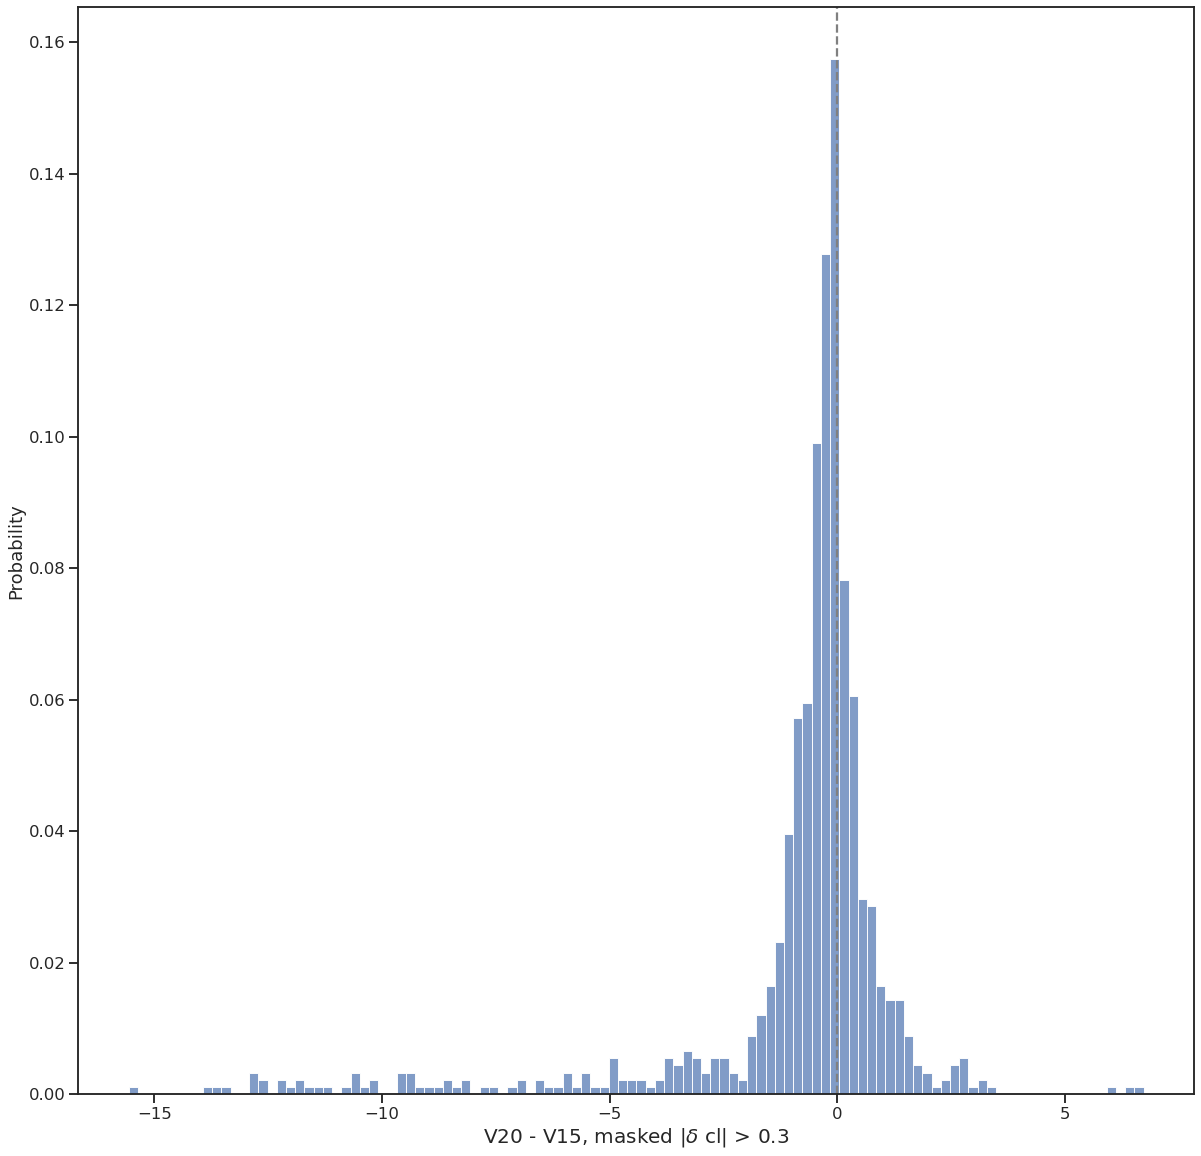

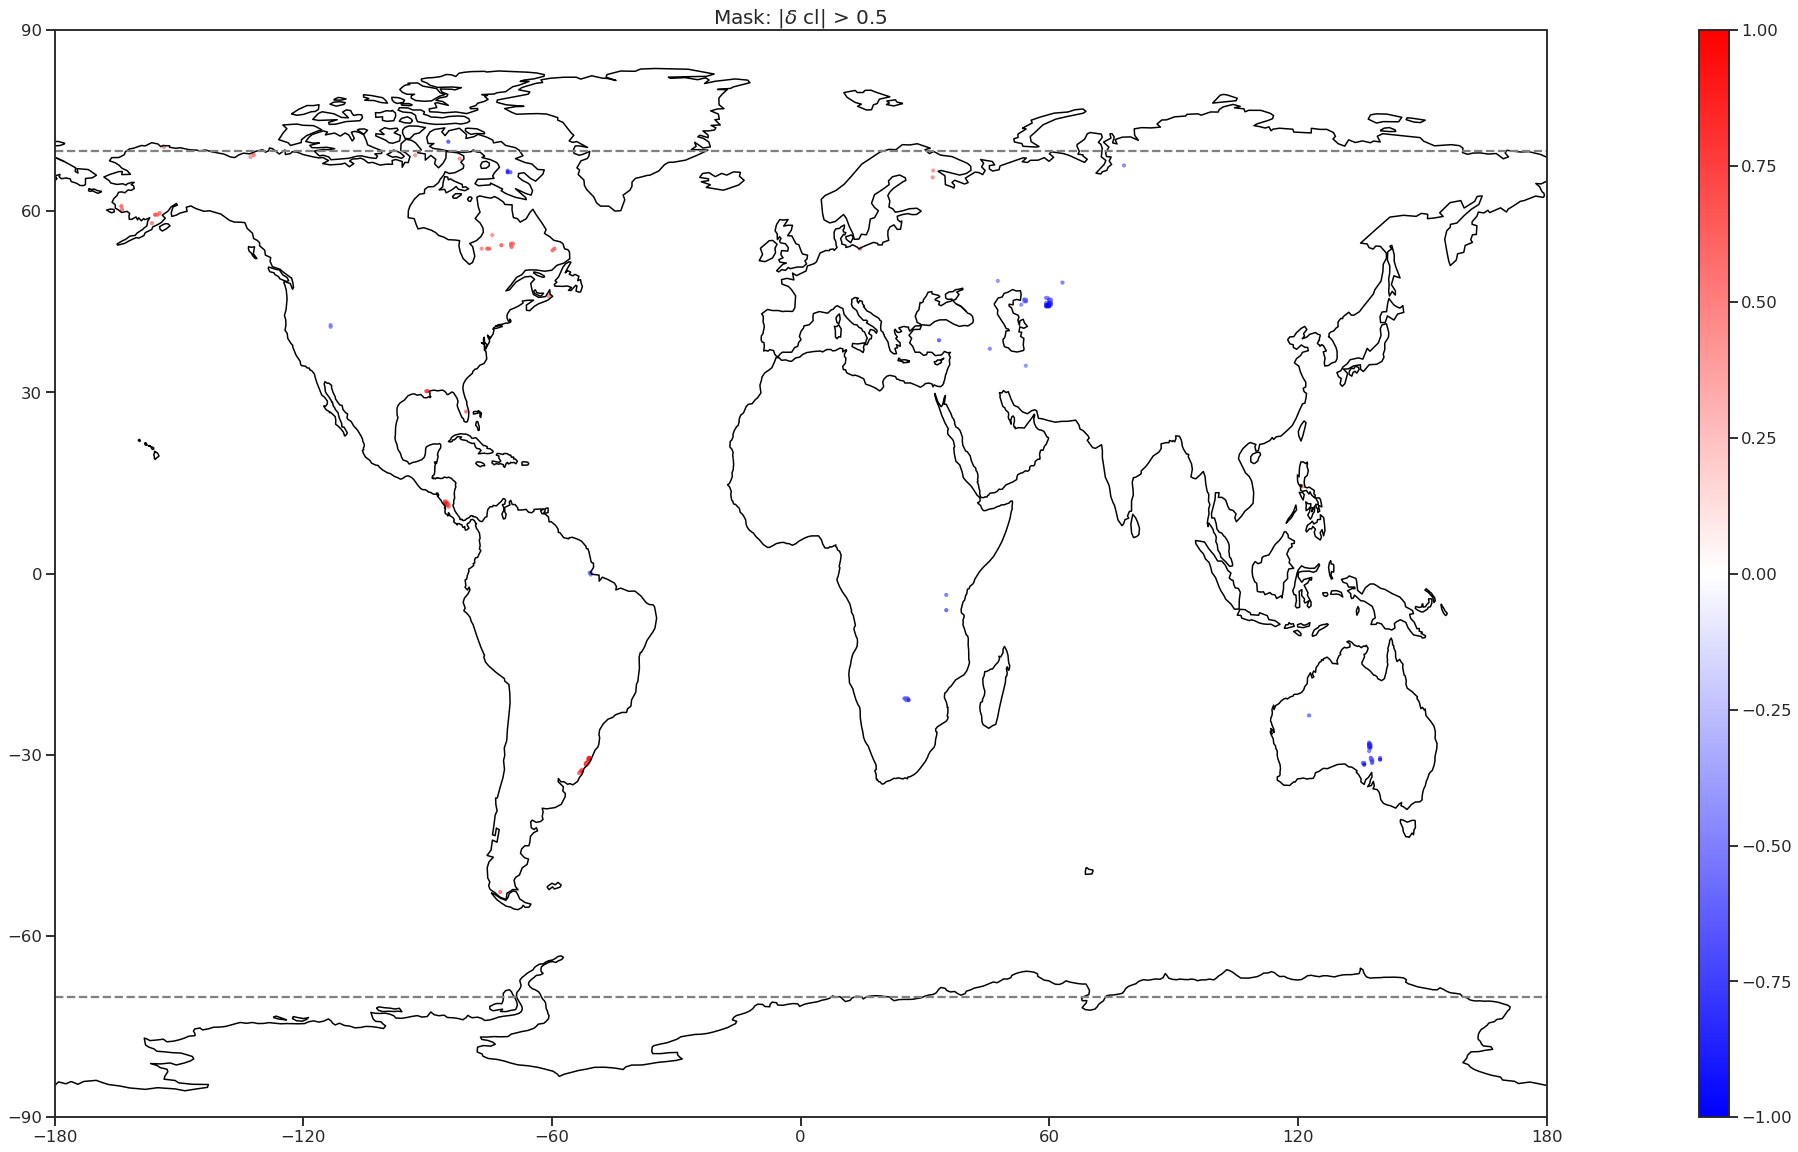

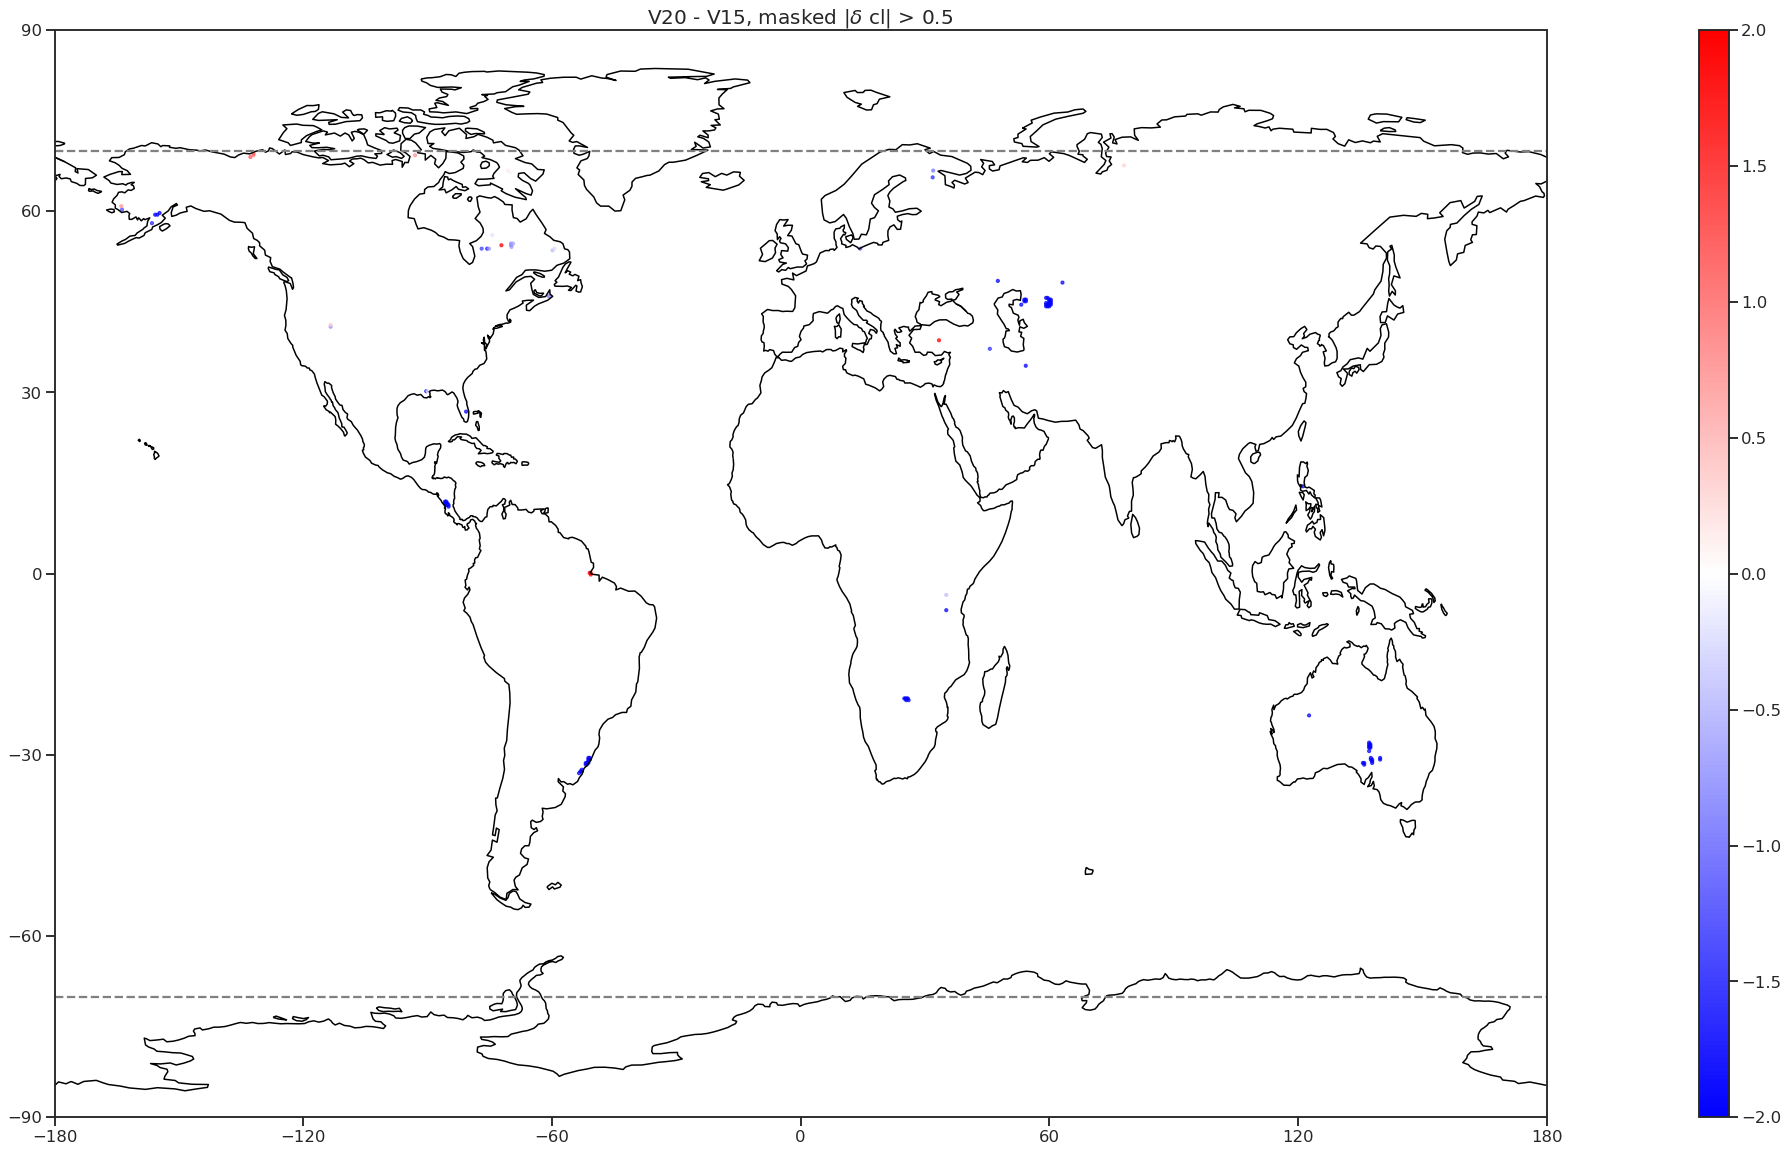

Number of samples: 115


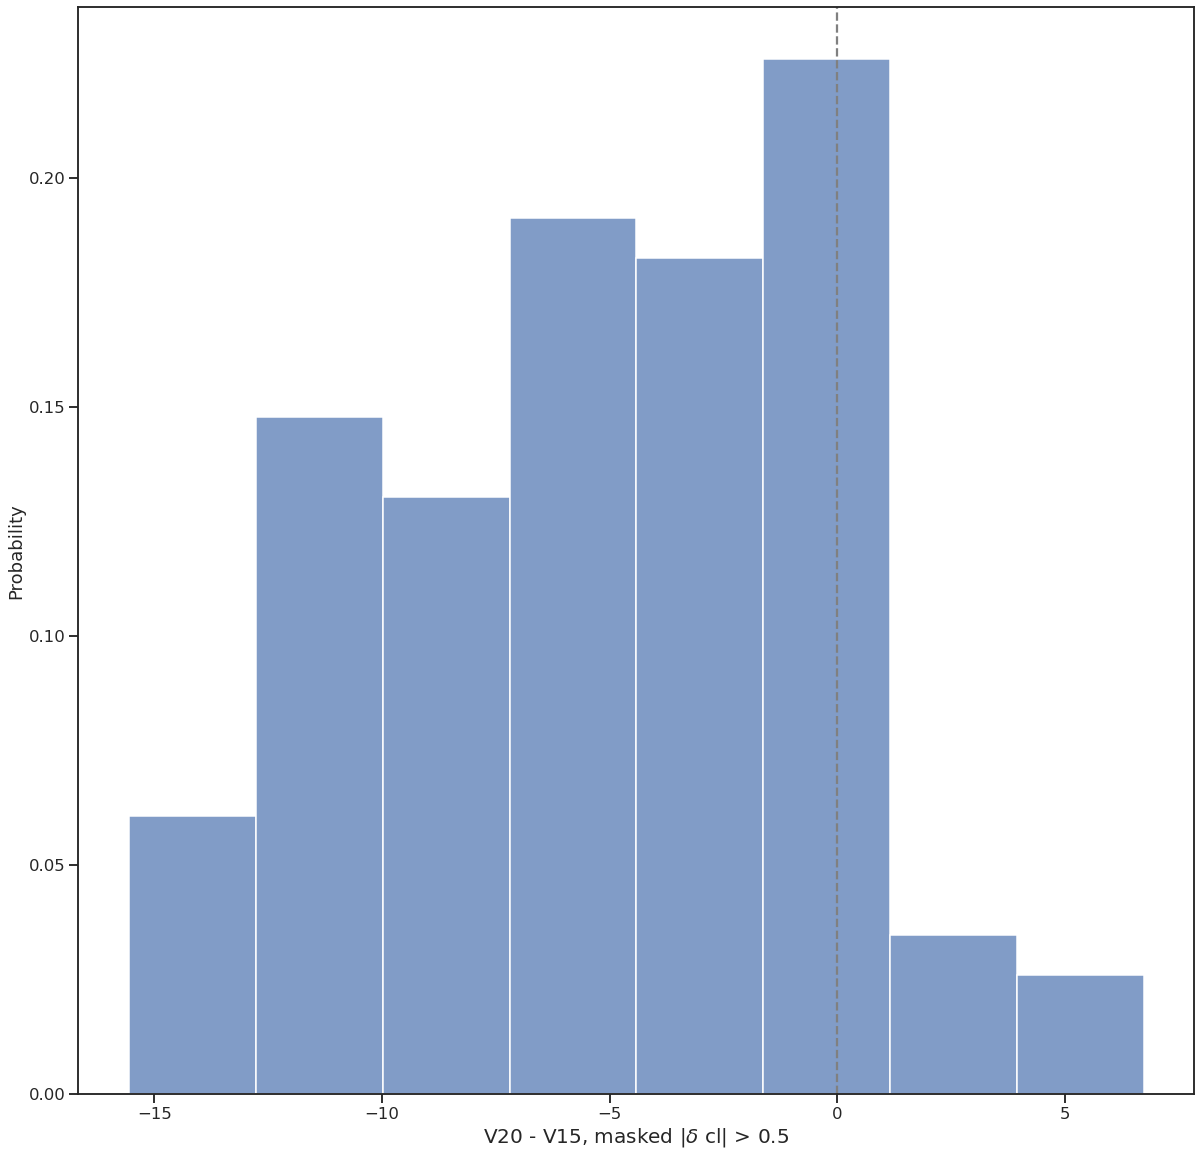

In [116]:
#Use cl delta field to create a mask 




#p = 0.1 # cutoff paramter. Only get points with change in lake cover > p

for p in [0.1,0.3,0.5]:

    #Create a mask
    mask = change_in_fields.query(f'abs(change_in_cl) > {p}')

    #Plot the mask
    plot_map(mask,'change_in_cl',vmin=-1,vmax=1,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}',limits=None,markersize=10) #What does this mask look like?


    #Apply the mask to the global error_delta_field from earlier
    V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

    # Plot it, along with a distribution of the errors
    plot_map(V20_V15_masked,
             'delta',
             vmin=-2,vmax=+2,
             cmap= plt.cm.bwr,
             logscale=False,
             title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}',
             limits=None,
             markersize=10)


    plot_distribution(V20_V15_masked,'delta',f'V20 - V15, masked |${{\delta}}$ cl| > {p}')
